
Pre Load packages

In [2]:
# load packages
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Pre Load data

'Video_id' is defined as the index of each sample. 'cvt_per_day' is the metric, the rest of 14 columns are all characteristic features (numeric & categorical) of each video.

In [3]:
TV = pd.read_table('TVdata.txt', sep = ',', header=0, lineterminator = '\n')
TV.head()

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.606,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.500,112.301,51,other award,PG-13,1.710
1,300175,270338.426,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.500,94.983,41,no award,R,3.250
2,361899,256165.867,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.300,115.764,58,other award,R,2.647
3,308314,196622.721,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.600,130.704,94,Oscar,R,1.667
4,307201,159841.652,1,3,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",46720,27220000,8551228,6.400,105.546,37,other award,R,3.067


In [4]:
print ("Number of rows:" + str(TV.shape[0]))
print ("Number of columns:" + str(TV.shape[1]))

Number of rows:4226
Number of columns:16


# Part 1: Data Exploration


1.1 Exclude erroneous data

Each video should only appear once in the list, duplicated video will be removed.

In [5]:
# check duplicated entry
if len(TV.set_index('video_id').index.get_duplicates()) == 0:
    print("There is no duplicated entry (video_id based).")
    

There is no duplicated entry (video_id based).


/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  


1.2 Understand the numerical features


1.2.1 Overview
Note: video_id, release_year are not numerical features although they are represented by numbers.

In [6]:
print (TV.drop(['video_id', 'release_year'],axis=1).describe(percentiles = [.1, .25, .5, .75, .95])) #测试mission value可能的区间，设定区间quantile，看看数值在哪些个区域
print(((TV == 0).sum()))## tv==0这个0是tv里面每一个feature column的data看看是否有等于0的；而下面result的0 是 True and False (false=0, True = 1), sum是所有0，1，0，1 boolean numbers的总和 -- 看第二个print的table 内容（只有六个非0）说明这六个里有missing values
print (TV.dtypes)


       cvt_per_day  weighted_categorical_position  \
count     4226.000                       4226.000   
mean      4218.630                          7.783   
std      13036.080                          6.134   
min          2.188                          1.000   
10%        141.985                          3.000   
25%        351.169                          4.000   
50%       1193.500                          6.000   
75%       3356.789                          9.000   
95%      14692.834                         22.000   
max     307127.606                         41.000   

       weighted_horizontal_poition  imdb_votes        budget     boxoffice  \
count                     4226.000    4226.000      4226.000      4226.000   
mean                        28.104    6462.924   2150743.439   2536338.472   
std                         11.864   31596.007   7176604.483   8243516.266   
min                          1.000       0.000         0.000         0.000   
10%                       

Among the 10 numerical features (not include video_id and release_year), 4 features have over 25% of missing data: budget, boxoffice, metacritic_score, star_category. 2 features have less than 10% of missing data: imdb_votes, imdb_rating.

（例如rating min是0，说明有missing value，但是10%》0说明有不超过10%的missing value

1.2.2 cvt_per_day feature

/Users/apple/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


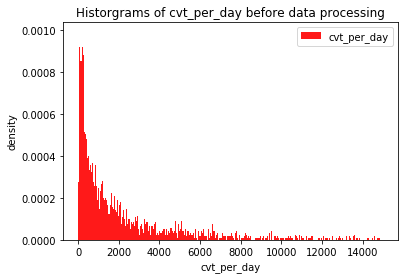

/Users/apple/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


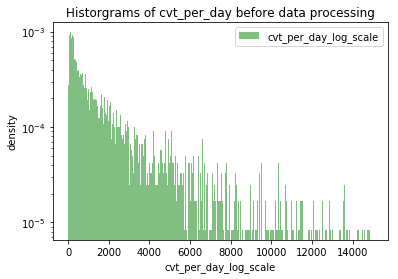

In [7]:
# cvt_per_day data explore
plt.hist(TV['cvt_per_day'].values, bins = range(0,15000, 30), alpha = 0.9, color='r', label = 'cvt_per_day', normed = True) #alpha 是颜色透明度
plt.legend(loc ='upper right')
plt.title('Historgrams of cvt_per_day before data processing')
plt.xlabel('cvt_per_day') #上面那个lablel是表示legent的label，xlable是展现x,y 轴名称
plt.ylabel('density')
plt.show()

# log scale of y due to large variation
plt.hist(TV['cvt_per_day'].values, log = True, bins = range(0,15000, 30), alpha = 0.5, color='g', label = 'cvt_per_day_log_scale', normed = True)
plt.legend(loc ='upper right')
plt.title('Historgrams of cvt_per_day before data processing')
plt.xlabel("cvt_per_day_log_scale")
plt.ylabel('density')
plt.show()

1.2.3 Correlation among numerical features

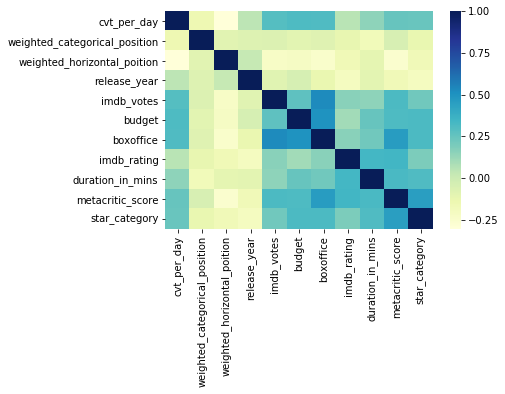

In [8]:
# correlation of the numerical features 

#Seaborn (sns) is a Python library created for enhanced Data Visualization.

corr = TV[['cvt_per_day','weighted_categorical_position','weighted_horizontal_poition'
               ,'release_year', 'imdb_votes', 'budget', 'boxoffice' ,'imdb_rating', 
               'duration_in_mins', 'metacritic_score', 'star_category']].corr()

sns.heatmap(corr, cmap="YlGnBu")

In [9]:
corr

,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,release_year,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
cvt_per_day,1.000,-0.148,-0.302,0.046,0.298,0.316,0.312,0.059,0.152,0.249,0.247
weighted_categorical_position,-0.148,1.000,-0.084,-0.069,-0.064,-0.090,-0.074,-0.116,-0.174,-0.044,-0.123
weighted_horizontal_poition,-0.302,-0.084,1.000,0.027,-0.221,-0.211,-0.245,-0.162,-0.102,-0.255,-0.168
release_year,0.046,-0.069,0.027,1.000,-0.083,-0.040,-0.128,-0.199,-0.097,-0.167,-0.198
imdb_votes,0.298,-0.064,-0.221,-0.083,1.000,0.273,0.531,0.163,0.156,0.322,0.225
budget,0.316,-0.090,-0.211,-0.040,0.273,1.000,0.505,0.106,0.251,0.315,0.322
boxoffice,0.312,-0.074,-0.245,-0.128,0.531,0.505,1.000,0.164,0.226,0.465,0.322
imdb_rating,0.059,-0.116,-0.162,-0.199,0.163,0.106,0.164,1.000,0.344,0.347,0.192
duration_in_mins,0.152,-0.174,-0.102,-0.097,0.156,0.251,0.226,0.344,1.000,0.327,0.309
metacritic_score,0.249,-0.044,-0.255,-0.167,0.322,0.315,0.465,0.347,0.327,1.000,0.452


1.3 Understand the categorical features

1.3.1 simple categorical features (import_id, mpaa, awards)

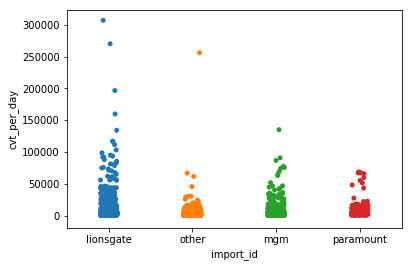

       index  import_id
0      other       2963
1  lionsgate        677
2        mgm        445
3  paramount        141


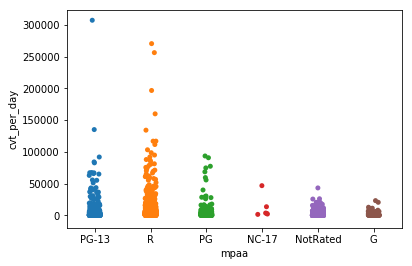

      index  mpaa
0  NotRated  2158
1         R  1158
2     PG-13   426
3        PG   353
4         G   125
5     NC-17     6


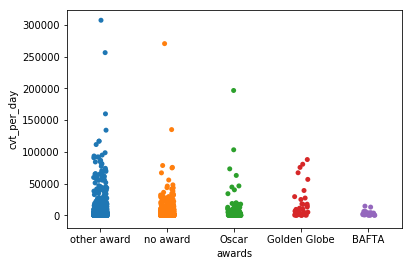

          index  awards
0      no award    2569
1   other award    1453
2         Oscar     141
3  Golden Globe      44
4         BAFTA      19


In [10]:
sns.stripplot(x='import_id', y='cvt_per_day', data=TV, jitter=True) #Jitter(抖动)： Amount of jitter (only along the categorical axis) to apply. This can be useful when you have many points and they overlap, so that it is easier to see the distribution. You can specify the amount of jitter (half the width of the uniform random variable support), or just use True for a good default.
plt.show()
print (TV['import_id'].value_counts().reset_index())

sns.stripplot(x='mpaa', y='cvt_per_day', data=TV, jitter=True)
plt.show()
print (TV['mpaa'].value_counts().reset_index())

sns.stripplot(x='awards', y='cvt_per_day', data=TV, jitter=True)
plt.show()
print (TV['awards'].value_counts().reset_index())

1.3.2 Distribution of splited genres

Some videos belongs to more than 1 genre, the genre of each video is splited, this would help emphasize the effect of each individual genre.

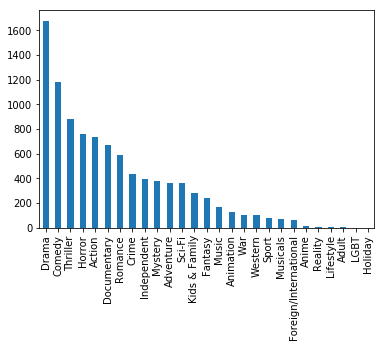

In [11]:
# generes explore, split the genre of each video
gen_split = TV['genres'].str.get_dummies(sep=',').sum()
gen_split.sort_values(ascending=False).plot.bar()

6 genres including Anime, Reality, Lifestyle, Adult, LGBT, Holiday have low frequencies. Therefore, during feature processing, they will be grouped together as: 'Misc_gen' in the feature 'genres'.

1.3.3 Distribution of release_year

The release year of video varies through a wide range. Considering the popularity of a video usually decays over time, the release_year should be bucketed based on the release_year range.

/Users/apple/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


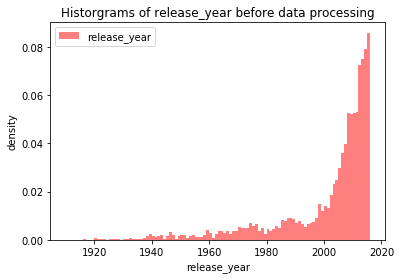

count   4226.000
mean    2001.057
std       17.497
min     1916.000
10%     1974.000
20%     1991.000
30%     2001.000
40%     2006.000
50%     2008.000
60%     2010.000
70%     2012.000
80%     2013.000
90%     2014.000
max     2017.000
Name: release_year, dtype: float64


In [12]:
plt.figure(1) #create a figure object and modify the size (图像的长宽 - plt.figure(figsize=(6,3)))
plt.hist(TV['release_year'].values, bins = range(1910, 2017, 1), alpha = 0.5, color='r', label = 'release_year', normed = True)
plt.legend(loc ='upper left')
plt.title('Historgrams of release_year before data processing')
plt.xlabel('release_year')
plt.ylabel('density')
plt.show()

print(TV['release_year'].describe(percentiles = [.1, .2, .3, .4,.5, .6, .7, .8, .9]))


# Part 2: Feature Preprocessing

2.1 Categorical features

There are 5 categorical features: import_id, mpaa, awards, genres, and release_year. There is no missing data in them. They can be converted into dummy/indicators.

The first 3 have relatively small sub-types, they can be easily converted to dummies.

The 'genres' have 27 different sub-types, 6 of them are rarely observed (refer to previous section). It's reasonable to group these 6 into 1. Note: a video may have more than one genre, in the feature preprocessing, all genres are handled individually.

The release_year is bined into 10 buckets based on the year range between 1917 and 2017.

In [13]:
# Convert 3 Categorical variables into dummy variables
d_import_id = pd.get_dummies(TV['import_id']).astype(np.int64)
d_mpaa = pd.get_dummies(TV['mpaa']).astype(np.int64)
d_awards = pd.get_dummies(TV['awards']).astype(np.int64)

In [14]:
# Convert 'genres' into dummy variables
d_genres = pd.DataFrame() 
for genre in ['Action', 'Adult', 'Adventure', 'Animation', 'Anime', 'Comedy', 'Crime', 'Documentary', 'Drama'
          , 'Fantasy', 'Foreign/International', 'Holiday', 'Horror', 'Independent', 'Kids & Family', 'LGBT', 
          'Lifestyle', 'Music', 'Musicals','Mystery', 'Reality', 'Romance','Sci-Fi', 'Sport', 'Thriller', 'War', 
          'Western']:
    gen_lst = []
    for i in range(4226):        
        if genre in TV['genres'][i]:  #row有4226个，然后index就是上面写的这些名称，是否对应用0，1对应。 ie 000100
            gen_lst.append(1)    
        else: 
            gen_lst.append(0)  
    d_genres[genre] = pd.Series(gen_lst).values
    
# combine 6 smallest genres into a new genre 'Misc_gen'. Use bitwise operation '|', then drop these 6 columns.
d_genres['Misc_gen'] = d_genres['Anime']|d_genres['Reality']|d_genres['Lifestyle']|d_genres['Adult']|d_genres['LGBT']|d_genres['Holiday']
d_genres.drop(['Anime', 'Reality','Lifestyle', 'Adult','LGBT','Holiday'], inplace=True, axis=1) #axis=1 表示column；这里表示删除6个名称及他们下面所有data


In [15]:
# bin release_year and convert into dummies
bin_year = [1916, 1974, 1991, 2001, 2006, 2008, 2010, 2012, 2013, 2014,2017]
year_range = ['1916-1974', '1974-1991', '1991-2001', '2001-2006','2006-2008','2008-2010','2010-2012','2012-2013',
              '2013-2014','2014-2017']
year_bin = pd.cut(TV['release_year'], bin_year, labels=year_range)
d_year = pd.get_dummies(year_bin).astype(np.int64)

In [16]:
d_year

,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0
5,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,1,0,0
9,0,0,0,0,0,1,0,0,0,0


In [17]:
# new dataframe, drop the previous categorical features, add new dummy variables, check for null
TV_temp = TV.drop(['import_id', 'mpaa','awards','genres', 'release_year'], axis=1)
newTV = pd.concat([TV_temp, d_import_id, d_mpaa, d_awards, d_genres, d_year], axis=1)
print (newTV.shape)
print (pd.isnull(newTV).any(1).nonzero()[0]) #检测是否有null data，1为axis=1说明看每一列的数，若有会被print出来，若没有就为（）空集，然后检测这个list的第一个（index 0）就可以知道是否有null data。
print (newTV.head())
newTV_0 = (newTV.copy()) # a copy of newTV

(4226, 58)
[]
   video_id  cvt_per_day  weighted_categorical_position  \
0    385504   307127.606                              1   
1    300175   270338.426                              1   
2    361899   256165.867                              1   
3    308314   196622.721                              3   
4    307201   159841.652                              1   

   weighted_horizontal_poition  imdb_votes    budget  boxoffice  imdb_rating  \
0                            3       69614  15000000   42930462        6.500   
1                            3       46705  15000000    3301046        6.500   
2                            3      197596  26000000   37397291        7.300   
3                            4      356339  15000000   15700000        7.600   
4                            3       46720  27220000    8551228        6.400   

   duration_in_mins  metacritic_score  ...  1916-1974  1974-1991  1991-2001  \
0           112.301                51  ...          0          0       

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  """


Feature space holds 4226 observations and 58 features in total.

There is NO null data. newTV_0 is kepted as the raw dataframe before any further feature processing, e.g. replace 0 with null, missing data fill etc.

2.2 Handling of missing data

Among the 10 numerical features (not include video_id), 4 features have over 25% of missing values (shown as '0', which is not possible in reality): budget, boxoffice, metacritic_score, star_category. 2 features have less than 10% of missing data: imdb_votes, imdb_rating.


There are 3242 samples have at least one missing data.

In [18]:
# mark zero values as NaN
newTV[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']] = newTV[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']].replace(0, np.nan)

# count the number of NaN values in each column
print (newTV.isnull().sum())

#count the number videos who have at least one missing data 
print ('videos having at least one null: ', newTV.isnull().any(axis=1).sum())

video_id                            0
cvt_per_day                         0
weighted_categorical_position       0
weighted_horizontal_poition         0
imdb_votes                        344
budget                           2454
boxoffice                        3194
imdb_rating                       344
duration_in_mins                    0
metacritic_score                 3012
star_category                    1846
lionsgate                           0
mgm                                 0
other                               0
paramount                           0
G                                   0
NC-17                               0
NotRated                            0
PG                                  0
PG-13                               0
R                                   0
BAFTA                               0
Golden Globe                        0
Oscar                               0
no award                            0
other award                         0
Action      

2.2.1 Filling missing data with mean value

For imdb_voates and imdb_rating, they always show 'null' together, which is reasonable, since when a imdb_votes is missing, the imdb_rating is mostly also missing. For all 6 features with missiong data, the 1st attempt is to fill in with their mean value.

In [19]:
# fill missing values with the column mean
newTV_i1 = newTV.copy()
newTV_i1['budget'].fillna(newTV_i1['budget'].mean(), inplace=True)
newTV_i1['boxoffice'].fillna(newTV_i1['boxoffice'].mean(), inplace=True)
newTV_i1['metacritic_score'].fillna(newTV_i1['metacritic_score'].mean(), inplace=True)
newTV_i1['star_category'].fillna(newTV_i1['star_category'].mean(), inplace=True)
newTV_i1['imdb_votes'].fillna(newTV_i1['imdb_votes'].mean(), inplace=True)
newTV_i1['imdb_rating'].fillna(newTV_i1['imdb_rating'].mean(), inplace=True)

newTV_i1 have the feature processing as: fill the missing data in budget, boxoffice, metacritic_score, star_category, imdb_votes, imdb_rating with mean. It will be tested in the upcoming models.

2.3 Feature scaling

The impact of different scaling methods on the model performance is small. In the following model training and selections, the standard scaling (sc) data is used.

In [20]:
#Standard scaling
scale_lst = ['weighted_categorical_position', 'weighted_horizontal_poition', 'budget','boxoffice', 
             'imdb_votes','imdb_rating','duration_in_mins', 'metacritic_score','star_category']
newTV_sc = newTV_i1.copy()

sc_scale = preprocessing.StandardScaler().fit(newTV_sc[scale_lst])  
newTV_sc[scale_lst] = sc_scale.transform(newTV_sc[scale_lst])

newTV_sc.head()



/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,...,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.606,-1.106,-2.116,1.984,1.470,4.696,0.542,1.079,-0.630,...,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426,-1.106,-2.116,1.258,1.470,-1.022,0.542,0.257,-1.997,...,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867,-1.106,-2.116,6.043,3.108,3.898,1.100,1.243,0.327,...,0,0,0,0,0,0,1,0,0,0
3,308314,196622.721,-0.780,-2.032,11.077,1.470,0.767,1.309,1.952,5.250,...,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652,-1.106,-2.116,1.258,3.290,-0.265,0.472,0.758,-2.544,...,0,0,0,0,0,0,0,1,0,0


Feature scaling is a method used to normalize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step.

Since the range of values of raw data varies widely, in some machine learning algorithms, objective functions will not work properly without normalization. For example, many classifiers calculate the distance between two points by the Euclidean distance. If one of the features has a broad range of values, the distance will be governed by this particular feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.

Another reason why feature scaling is applied is that gradient descent converges much faster with feature scaling than without it.

In [21]:
# MinMax scaling
newTV_mm = newTV_i1.copy()
mm_scale = preprocessing.MinMaxScaler().fit(newTV_mm[scale_lst])
newTV_mm[scale_lst] = mm_scale.transform(newTV_mm[scale_lst])

/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [22]:
# Robust scaling
newTV_rs = newTV_i1.copy()
rs_scale = preprocessing.RobustScaler().fit(newTV_mm[scale_lst])
newTV_rs[scale_lst] = rs_scale.transform(newTV_rs[scale_lst])

# Part 3: Model Training

85% of the samples will be used to train all the models, and 15% is reserved for test the models in next section.

In [23]:
# The 15% test data will kept aside, they won't be seen by the models until final test/comparison.
import numpy as np
from sklearn.model_selection import train_test_split

model_train, model_test = train_test_split(newTV_sc, test_size=0.15, random_state = 3)
model_train_x = model_train.drop(['video_id', 'cvt_per_day'], axis = 1) # x:features; y: label; x_test,x_train,y_test,y_train
model_test_x = model_test.drop(['video_id', 'cvt_per_day'], axis = 1)
model_train_y = model_train['cvt_per_day']
model_test_y = model_test['cvt_per_day']

3.1 Linear models

3.1.1 Lasso linear regression

--lasso: method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces.


1) All featuers are linear

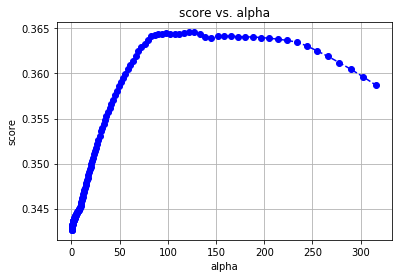

The optimaized alpha and score of Lasso linear is:  122.06107238906554 0.36457853302954235


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt



lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

alphas = np.logspace (-0.3, 2.5, num=150)
# alphas= [0.000000001]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_x, lr_train_y)
    scores[i] = lasso.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Lasso linear is: ', opt_a, max_score)

In [25]:
# combine the validate data and training data, use the optimal alpha, re-train the model
lasso_f = Lasso()
lasso_f.set_params(alpha = opt_a)
lasso_f.fit(model_train_x, model_train_y)

# lasso_f is the Lasso model (linear feature), to be tested with final test data.

Lasso(alpha=122.06107238906554, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

2) Polynomial features

 Polynomial features allows you to do non-linear regression /classification with a linear model

/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not co

/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not co

/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not co

/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not co

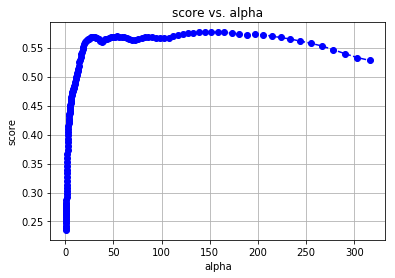

The optimaized alpha and score of Lasso polynomial is:  145.1259135021143 0.5765777629064802


In [26]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)

lr_train_xp = poly.fit_transform(lr_train_x)
lr_validate_xp = poly.fit_transform(lr_validate_x)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

#lr_train_xp = pd.DataFrame(data=lr_train_xp, index=data[:], columns=data[0,1:]) 
alphas = np.logspace (-0.3, 2.5, num=150)
#alphas = np.logspace (-2.6, 2.5, num=80)
# alphas= [1]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_xp, lr_train_y)
    scores[i] = lasso.score(lr_validate_xp, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
        
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Lasso polynomial is: ', opt_a, max_score)

In [27]:
# combine the validate data and training data, use the optimal alpha, re-train the model
lr_train_xp1 = poly.fit_transform(model_train_x)

lasso_fp = Lasso()
lasso_fp.set_params(alpha = opt_a)
lasso_fp.fit(lr_train_xp1, model_train_y)

# lasso_fp is the Lasso model (polynomial feature), to be tested with test data.

Lasso(alpha=145.1259135021143, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

3.1.2 Ridge linear regression


1) All featuers are linear

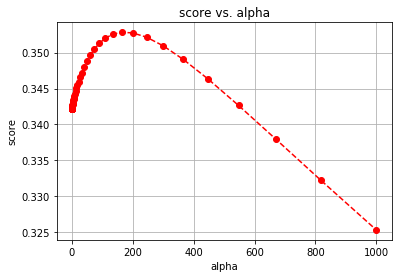

0.35284634333100806 163.97026580002054


In [28]:
# Use the same training data set as Lasso (linear features)
lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

alphas = np.logspace (-10, 3, num=150)
# alphas= [0.000000001]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = Ridge()
    ridge.set_params(alpha = a)
    ridge.fit(lr_train_x, lr_train_y)
    scores[i] = ridge.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        ridge_save = ridge
plt.plot(alphas, scores, color='r', linestyle='dashed', marker='o',markerfacecolor='r', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print (max_score, opt_a)


In [29]:
# add the 15% validate data, use the optimal alpha, re-train the model

ridge_f = Ridge()
ridge_f.set_params(alpha = opt_a)
ridge_f.fit(model_train_x, model_train_y)

# ridge_f is the Ridge model (linear feature), to be tested with test data.

Ridge(alpha=163.97026580002054, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

2) Polynomial featuers

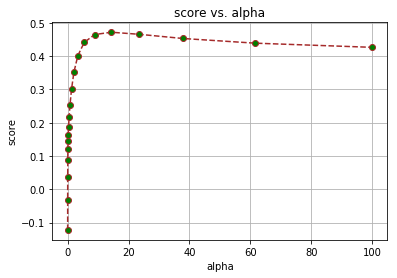

0.47188994690622155 14.38449888287663


In [30]:
# Use the same training data set as Lasso (polynomial features)
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)

lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

lr_train_xp = poly.fit_transform(lr_train_x)
lr_validate_xp = poly.fit_transform(lr_validate_x)

alphas = np.logspace (-2, 2, num=20)
# alphas= [1]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = Ridge()
    ridge.set_params(alpha = a)
    ridge.fit(lr_train_xp, lr_train_y)
    scores[i] = ridge.score(lr_validate_xp, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        ridge_save = ridge
        
plt.plot(alphas, scores, color='brown', linestyle='dashed', marker='o',markerfacecolor='g', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print (max_score, opt_a)


In [31]:
# add the 15% validate data, use the optimal alpha, re-train the model
lr_train_xp1 = poly.fit_transform(model_train_x)

ridge_fp = Ridge()
ridge_fp.set_params(alpha = opt_a)
ridge_fp.fit(lr_train_xp1, model_train_y)

# ridge_fp is the Ridge model (polynomial feature), to be tested with test data.

Ridge(alpha=14.38449888287663, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

3.2: Non-linear model


Random forest with Gridsearch cross-validation is used. The 'mean_scores' is used to narrow down the paramenters of n_estimator (number of trees in the forest) and Max_depth (maximum depth of the tree).

Random forest

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

rf_train, rf_test = train_test_split(model_train, test_size=0.15, random_state = 0)

rf_train_x = rf_train.drop(['video_id', 'cvt_per_day'], axis = 1)
rf_test_x = rf_test.drop(['video_id', 'cvt_per_day'], axis = 1)
rf_train_y = rf_train['cvt_per_day']
rf_test_y = rf_test['cvt_per_day']

param_grid = {
                 'n_estimators': [54, 55, 56, 57, 58, 59, 60, 62],
                 'max_depth': [12, 13, 14, 15, 16, 17]
             }  #找最match的parameter

rf = RandomForestRegressor(random_state=2, max_features = 'sqrt')
grid_rf = GridSearchCV(rf, param_grid, cv=5)
grid_rf.fit(rf_train_x, rf_train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=2, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [54, 55, 56, 57, 58, 59, 60, 62], 'max_depth': [12, 13, 14, 15, 16, 17]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
grid_rf.best_params_ 

{'max_depth': 14, 'n_estimators': 55}

In [34]:
grid_rf.cv_results_

/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/apple/anaconda3/lib/pyth

{'mean_fit_time': array([0.16362863, 0.15980339, 0.16778536, 0.18842959, 0.1695549 ,
        0.17448821, 0.17508087, 0.23228102, 0.17247934, 0.17970533,
        0.18413744, 0.21250458, 0.18469858, 0.18276744, 0.19067473,
        0.20642228, 0.18058348, 0.19180012, 0.19027791, 0.19818773,
        0.19227872, 0.20244799, 0.20268893, 0.21071491, 0.19207435,
        0.20257998, 0.26562276, 0.22577853, 0.24460402, 0.22305512,
        0.21451163, 0.2256012 , 0.20243878, 0.21033831, 0.20893569,
        0.21513991, 0.21852732, 0.22825828, 0.22833514, 0.23008347,
        0.21244626, 0.21653523, 0.22225041, 0.22641249, 0.22488556,
        0.2319293 , 0.23709598, 0.26107492]),
 'std_fit_time': array([0.0086048 , 0.0016162 , 0.00839851, 0.00641198, 0.00257855,
        0.00735821, 0.00289936, 0.03884933, 0.00467362, 0.00981208,
        0.0062045 , 0.02748694, 0.00417326, 0.00092676, 0.00740216,
        0.01024501, 0.00290314, 0.01359774, 0.00577453, 0.00780279,
        0.00159706, 0.00955175, 0.005

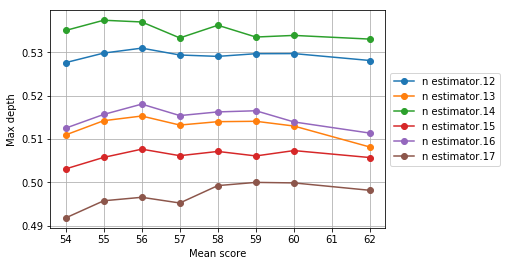

In [35]:
# plot the effect of different number of trees and maximum tree-depth druing cross validation 
scores = grid_rf.cv_results_['mean_test_score']

n_est = [54, 55, 56, 57, 58, 59, 60, 62]
m_depth=[12, 13, 14, 15, 16, 17]
scores = np.array(scores).reshape(len(m_depth), len(n_est))
fig = plt.figure()
ax = plt.subplot(111)
for ind, i in enumerate(m_depth):
    plt.plot(n_est, scores[ind], '-o', label='n estimator.' + str(i),)
    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Mean score')
plt.ylabel('Max depth')
plt.grid(True)
plt.show()
# savefig('rf_1')

In [36]:
# add both training and validation data together as the new training data
rf = RandomForestRegressor(random_state=2, max_features = 'sqrt', max_depth= 14, n_estimators=55)
rf.fit(model_train_x, model_train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=55, n_jobs=None,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

The best rf model have n_estimator = 14, and max_depth = 55.

# Part 4: Model Evaluation

test data is the reserved 15% of the whole dataset, and has never been seen by the above models.



4.1 Lasso test with linear features (lasso_f)

In [37]:
# Lasso_f test (with linear features)

lasso_f_score = lasso_f.score(model_test_x, model_test_y)
pred_y = lasso_f.predict(model_test_x)

# The mean squared error and root mean square error
MSE_lasso_f = mean_squared_error(model_test_y, pred_y)
RMSE_lasso_f = sqrt(mean_squared_error(model_test_y, pred_y))

print ('lasso_f score: ', lasso_f_score)
print ('Mean square error of lasso_f: ', MSE_lasso_f)
print ('Root mean squared error of lasso_f:', RMSE_lasso_f)
# print ('Coefficients of lasso_f: ', lasso_f.coef_)

lasso_f score:  0.09954927178753703
Mean square error of lasso_f:  238953191.99910036
Root mean squared error of lasso_f: 15458.110880670392


4.2 Lasso test with polynomial features (lasso_fp)

In [39]:
# Lasso_fp test (with polynomial features)
model_test_xp = poly.fit_transform(model_test_x)
pred_y = lasso_fp.predict(model_test_xp)

lasso_fp_score = lasso_fp.score(model_test_xp, model_test_y)
MSE_lasso_fp = mean_squared_error(model_test_y, pred_y)
RMSE_lasso_fp = sqrt(mean_squared_error(model_test_y, pred_y))

print ('lasso_fp score: ', lasso_fp_score)
print ('Mean square error of lasso_fp: ', MSE_lasso_fp)
print ('Root mean squared error of lasso_fp:', RMSE_lasso_fp)
# print ('Coefficients of lasso_fp: ', lasso_fp.coef_)

lasso_fp score:  -0.08724355239922987
Mean square error of lasso_fp:  288522524.5383296
Root mean squared error of lasso_fp: 16985.950798772777


4.3 Ridge test with linear features (ridge_f)

In [40]:
ridge_f_score = ridge_f.score(model_test_x, model_test_y)
pred_y = ridge_f.predict(model_test_x)

# The mean squared error and root mean square error
MSE_ridge_f = mean_squared_error(model_test_y, pred_y)
RMSE_ridge_f = sqrt(mean_squared_error(model_test_y, pred_y))

print ('ridge_f score: ', ridge_f_score)
print ('Mean square error of ridge_f: ', MSE_ridge_f)
print ('Root mean squared error of ridge_f:', RMSE_ridge_f)
# print ('Coefficients of ridge_f: ', ridge_f.coef_)

ridge_f score:  0.11379706231843734
Mean square error of ridge_f:  235172246.6129472
Root mean squared error of ridge_f: 15335.326752728393


4.4 Ridge test with polynomial features (ridge_fp)

In [41]:
# ridge_fp test (with polynomial features)
model_test_xp = poly.fit_transform(model_test_x)

ridge_fp_score = ridge_fp.score(model_test_xp, model_test_y)
MSE_ridge_fp = mean_squared_error(model_test_y, pred_y)
RMSE_ridge_fp = sqrt(mean_squared_error(model_test_y, pred_y))

pred_y = ridge_fp.predict(model_test_xp)
print ('ridge_fp score: ', ridge_f_score)
print ('Mean square error of ridge_fp: ', MSE_ridge_fp)
print ('Root mean squared error of ridge_fp:', RMSE_ridge_fp)
#print ('Coefficients of ridge_fp: ', ridge_fp.coef_)

ridge_fp score:  0.11379706231843734
Mean square error of ridge_fp:  235172246.6129472
Root mean squared error of ridge_fp: 15335.326752728393


4.5 Random forest test (rf)

In [42]:
rf_score = rf.score(model_test_x, model_test_y)

pred_y = rf.predict(model_test_x)
MSE_rf = mean_squared_error(model_test_y, pred_y)
RMSE_rf = sqrt(mean_squared_error(model_test_y, pred_y))

# The mean squared error and root mean square error
print ('rf score: ', rf_score)
print ('Mean square error of rf: ', MSE_rf)
print ('Root mean squared error of rf:', RMSE_rf)
# print('Coefficients: \n', ridge_fp.coef_)

rf score:  0.5098577869271956
Mean square error of rf:  130069356.02101581
Root mean squared error of rf: 11404.79530815945


4.6 Comparison of the 5 models

Compared the max_score, mean squared error (MSE), and root mean squared error (RMSE) of 5 models. Random forest model rf returns the beset prediction accuracy.

No handles with labels found to put in legend.


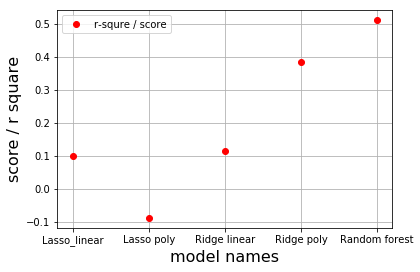

No handles with labels found to put in legend.


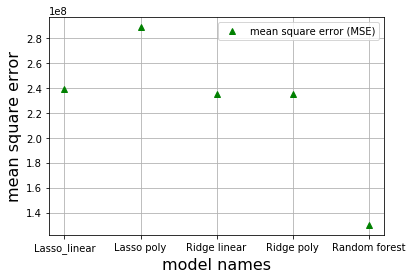

No handles with labels found to put in legend.


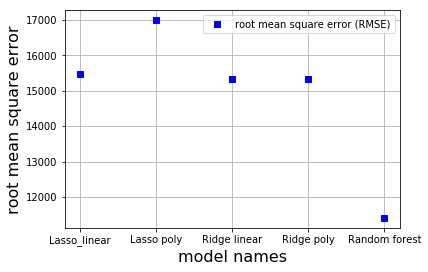

In [44]:
lst_score = [lasso_f_score, lasso_fp_score, ridge_f_score, ridge_fp_score, rf_score]
MSE_lst =  [MSE_lasso_f, MSE_lasso_fp, MSE_ridge_f, MSE_ridge_fp, MSE_rf]
RMSE_lst =  [RMSE_lasso_f, RMSE_lasso_fp, RMSE_ridge_f, RMSE_ridge_fp, RMSE_rf]
model_lst = ['Lasso_linear','Lasso poly', 'Ridge linear', 'Ridge poly', 'Random forest']

plt.figure(1)
plt.plot(model_lst, lst_score, 'ro')
plt.legend(loc = 9)
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(model_lst, MSE_lst, 'g^')
plt.legend(loc = 9)
plt.legend(['mean square error (MSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(3)
plt.plot(model_lst, RMSE_lst, 'bs')
plt.legend(loc = 9)
plt.legend(['root mean square error (RMSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('root mean square error', fontsize =16)
plt.grid(True)
plt.show()


# 5. Feature importance

Random forest(RF) shows the best prediction accuracy. Therefore, the feature importance will be extracted from the RF model.

Feature importance ranking:
1. feature 2 weighted_categorical_position (0.153114)
2. feature 0 weighted_horizontal_poition (0.125979)
3. feature 1 imdb_votes (0.122217)
4. feature 7 budget (0.058824)
5. feature 8 boxoffice (0.056730)
6. feature 3 imdb_rating (0.055224)
7. feature 4 duration_in_mins (0.054734)
8. feature 6 metacritic_score (0.042676)
9. feature 9 star_category (0.039899)
10. feature 5 lionsgate (0.032440)
11. feature 11 mgm (0.027291)
12. feature 53 other (0.025557)
13. feature 10 paramount (0.020731)
14. feature 42 G (0.017618)
15. feature 28 NC-17 (0.012257)
16. feature 18 NotRated (0.011334)
17. feature 27 PG (0.010325)
18. feature 49 PG-13 (0.007859)
19. feature 52 R (0.007672)
20. feature 23 BAFTA (0.007548)
21. feature 30 Golden Globe (0.006129)
22. feature 15 Oscar (0.005517)
23. feature 29 no award (0.005429)
24. feature 51 other award (0.005089)
25. feature 17 Action (0.005000)
26. feature 50 Adventure (0.004992)
27. feature 24 Animation (0.004810)
28. feature 

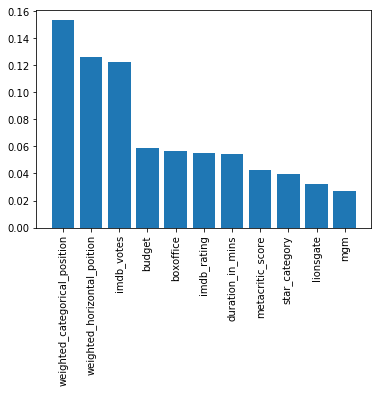

In [45]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_name = model_test_x.columns.get_values()

# Print the feature ranking
print("Feature importance ranking:")

for f in range(model_test_x.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f],  feature_name[f], importances[indices[f]]))
    
plt.figure(1)
plt.bar(feature_name[:11], importances[indices[:11]])
plt.xticks(rotation=90) #rotate x label text 让x轴的子是垂直的
plt.show()